In [1]:
from encode import sample_files, get_units
from utils.features import DataSet
from pathlib import Path

dataset = DataSet(
    name="librispeech-dev-clean",
    in_dir=Path("data/dev-clean"),
    align_dir=Path("data/alignments/dev-clean"),
    feat_dir=Path("features"), 
    audio_ext=".flac" 
)

sampled_paths = sample_files(dataset, 400)

# sampled_paths = [
#     Path("data/dev-clean/174/50561/174-50561-0005.flac"), 
#     Path("data/dev-clean/3081/166546/3081-166546-0058.flac"), 
#     Path("data/dev-clean/84/121550/84-121550-0026.flac")]
print(len(sampled_paths))

400


In [2]:
from distance import load_units
from joblib import Parallel, delayed

results = Parallel(n_jobs=2)([
    delayed(load_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

# hubert_words, dusted_words = load_units(dataset, sampled_paths, 0.2)

Loading Units: 100%|██████████| 400/400 [01:56<00:00,  3.45it/s]


In [ ]:

hubert_words, dusted_words = get_units(dataset, sampled_paths, 0.2)


Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units: 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


In [3]:
from collections import Counter

num_words = len(hubert_words)
true_words = []

avg_words = []
for w in range(num_words): 

    new_word = hubert_words[w].copy()
    hubert_units = hubert_words[w].clean_encoding
    dusted_units = dusted_words[w].clean_encoding

    common_units = list(dict.fromkeys(unit for unit in hubert_units if unit in dusted_units))
    new_word.update_encoding(common_units)
    avg_words.append(new_word)

    if not isinstance(new_word.true_word, str):
        true_words.append("_")
    else:
        true_words.append(new_word.true_word)
        

counts = Counter(true_words)
not_ones = {}
for c in counts:
    if counts[c] > 1:
        not_ones[c] = counts[c]
sorted_word_counts = dict(sorted(not_ones.items(), key=lambda item: item[1], reverse=True))
print(sorted_word_counts)


{'_': 1352, 'the': 542, 'and': 317, 'of': 263, 'to': 225, 'a': 163, 'in': 119, 'i': 105, 'was': 105, 'his': 100, 'that': 97, 'it': 95, 'he': 91, 'for': 77, 'with': 77, 'had': 63, 'as': 60, 'not': 58, 'is': 54, 'but': 54, 'her': 51, 'at': 49, 'on': 47, 'you': 46, 'have': 45, 'they': 43, 'my': 39, 'this': 39, 'him': 39, 'them': 39, 'one': 38, 'or': 38, 'be': 37, 'which': 37, 'their': 36, 'she': 35, 'all': 34, 'no': 32, 'were': 32, 'are': 31, 'an': 31, 'from': 29, 'by': 28, 'so': 27, 'up': 27, 'into': 27, 'when': 25, '<unk>': 25, 'we': 25, 'out': 24, 'what': 24, 'there': 23, 'will': 23, 'me': 22, 'more': 21, 'could': 20, 'very': 20, 'would': 20, 'said': 20, 'now': 18, 'over': 18, 'been': 18, 'then': 17, 'if': 17, 'like': 17, 'any': 17, 'should': 17, 'other': 16, 'little': 16, 'do': 15, 'made': 15, 'who': 15, 'once': 14, 'down': 14, 'only': 14, 'time': 14, 'our': 14, 'did': 14, 'such': 14, 'has': 14, 'than': 13, 'put': 13, 'two': 13, 'upon': 13, 'about': 13, 'own': 13, 'can': 12, 'how': 12

In [4]:
true_clusters = []
for i in sorted_word_counts:
    clust = []
    for k in range(sorted_word_counts[i]):
        clust.append(i)
    true_clusters.append(clust)


In [5]:
import pandas as pd
import ace_tools_open as tools

word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)


Sorted Word Counts


In [6]:
import numpy as np 
from tqdm import tqdm
import editdistance

num_words = len(hubert_words)

dist_mat_hub = np.zeros((num_words, num_words))
dist_mat_dust = np.zeros((num_words, num_words))
for i in tqdm(range(num_words), desc="Calculating Distances"):
    
    for j in range(i+1, num_words):
        if len(hubert_words[i].clean_encoding) + len(hubert_words[j].clean_encoding) == 0: 
            dist_mat_hub[i, j] = 0
        else:
            dist_mat_hub[i, j] = editdistance.eval(hubert_words[i].clean_encoding, hubert_words[j].clean_encoding)/(len(hubert_words[i].clean_encoding) + len(hubert_words[j].clean_encoding))
        dist_mat_hub[j, i] = dist_mat_hub[i, j]
        if len(dusted_words[i].clean_encoding) + len(dusted_words[j].clean_encoding) == 0:
            dist_mat_dust[i, j] = 0
        else:
            dist_mat_dust[i, j] = editdistance.eval(dusted_words[i].clean_encoding, dusted_words[j].clean_encoding)/(len(dusted_words[i].clean_encoding) + len(dusted_words[j].clean_encoding))
        dist_mat_dust[j, i] = dist_mat_dust[i, j]


Calculating Distances:  27%|██▋       | 2634/9824 [02:16<06:11, 19.36it/s]


KeyboardInterrupt: 

In [7]:
from distance import calculate_distance

dist_mat_dusted = calculate_distance(dusted_words, Path("output/dusted/400"))
print()
dist_mat_hubert = calculate_distance(hubert_words, Path("output/hubert/400"))

Calculating Distances: 100%|██████████| 9824/9824 [01:40<00:00, 98.19it/s] 


[[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0.]]



Calculating Distances: 100%|██████████| 9824/9824 [02:33<00:00, 63.86it/s] 


[[0.    1.    1.    1.    1.   ]
 [1.    0.    1.    0.875 1.   ]
 [1.    1.    0.    1.    1.   ]
 [1.    0.875 1.    0.    1.   ]
 [1.    1.    1.    1.    0.   ]]


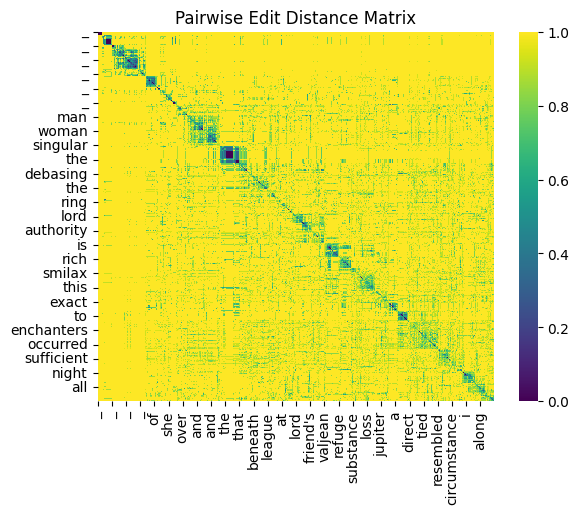

In [8]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

condensed_dist_mat = squareform(dist_mat_dusted)

dist_df_dust = pd.DataFrame(dist_mat_dusted, index=true_words, columns=true_words)

linked = linkage(condensed_dist_mat, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_dust.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

In [14]:
dust_clusters = cluster(dist_mat_dusted, 0.2)

dust_word_clusters = []
for d, d_clust in enumerate(dust_clusters):
    clust = []
    
    for k in range(len(d_clust)):
        word_k = [w for w in dusted_words if w.id == d_clust[k]]
        clust.append(word_k[0].true_word)
    dust_word_clusters.append(clust)


In [15]:
           
for d, d_clust in enumerate(dust_clusters):
    if len(d_clust)>1:
        print(f"Cluster {d}")
        for k in range(len(d_clust)):
            word_k = [w for w in dusted_words if w.id == d_clust[k]]
            print(word_k[0].true_word)
        print()

Cluster 2
friend
friend
friend

Cluster 3
a
a

Cluster 6
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of

Cluster 7
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_

Cluster 9
my
my
my
my

Cluster 14
then
than
than
than
then

Cluster 17
and
and

Cluster 18
_
_
_
_
_
_

Cluster 24
i
i
i
i
i
i

Cluster 25
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
and
in
and
and
and
and
and
and
and

Cluster 27
came
came

Cluster 28
he
he
he
he

Cluster 30
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_

Cluster 33
no
no
no
know
no
know
no
no
no
no
no
know
know

Cluster 35
gave
gave

Cluster 36
she
she
she

Cluster 39
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to
to

Cluster 43
i
i
i
i
i
i
i
i
i
i
i
i
i

Cluster 47
is
is
is

Clust

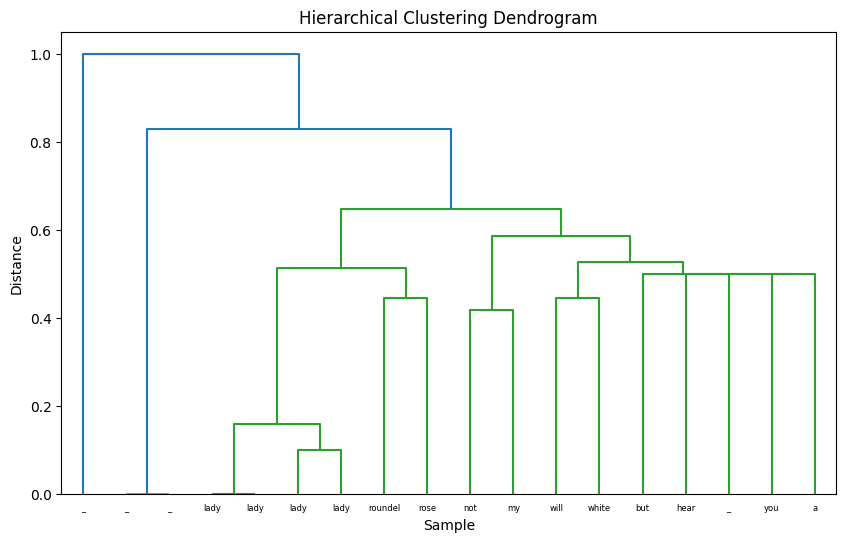

In [46]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
r = dendrogram(linked, labels=true_words, leaf_font_size=6)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()


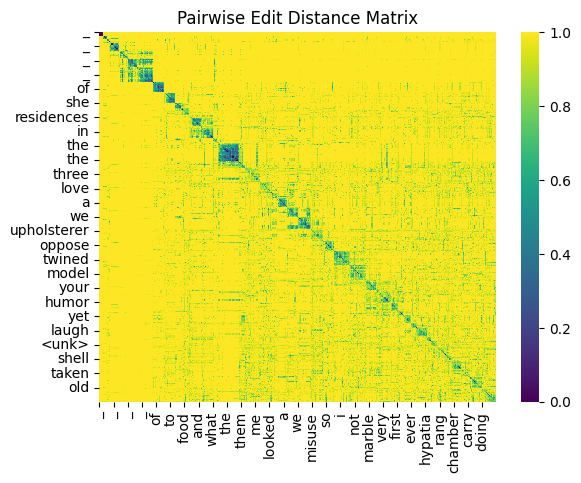

In [11]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

condensed_dist_mat = squareform(dist_mat_hubert)
dist_df_hub = pd.DataFrame(dist_mat_hubert, index=true_words, columns=true_words)
linked = linkage(condensed_dist_mat, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_hub.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()


In [13]:

hub_clusters = cluster(dist_mat_hubert, 0.2)

for h, h_clust in enumerate(hub_clusters):
    if len(h_clust)>1:
        print(f"Cluster {h}")
        for k in range(len(h_clust)):
            word_k = [w for w in dusted_words if w.id == h_clust[k]]
            print(word_k[0].true_word)
        print()

Cluster 6
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
have
of
of
of
have
have
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
have
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of
of

Cluster 7
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_

Cluster 9
my
my

Cluster 14
then
then
then

Cluster 18
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_

Cluster 30
_
_
_
_

Cluster 31
to
to
to
to
to
to
to
to


In [24]:
import itertools
import editdistance
import statistics

def ned(clusters):
    distances = []
    for i, clust in enumerate(clusters):
        clust_dist = []
        if len(clust)> 1:
            print(f"Cluster {i}")
            for p, q in itertools.combinations(clust, 2):
                print((p.true_word, q.true_word))
                distance = editdistance.eval(p.true_word, q.true_word)
                clust_dist.append(distance)
                distances.append(distance)
            print(statistics.mean(clust_dist))
        
    return statistics.mean(distances)


In [26]:
all_words = []
for d, d_clust in enumerate(dust_clusters):
    words = []
    for k in range(len(d_clust)):
        word_k = [w for w in dusted_words if w.id == d_clust[k]]
        words.append(word_k[0])
    all_words.append(words)

norm_edit_dist = ned(all_words)
print(norm_edit_dist)

Cluster 2
('friend', 'friend')
('friend', 'friend')
('friend', 'friend')
0
Cluster 3
('a', 'a')
0
Cluster 6
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', '

In [25]:
all_words = []
for h, h_clust in enumerate(hub_clusters):
    words = []
    for k in range(len(h_clust)):
        word_k = [w for w in dusted_words if w.id == h_clust[k]]
        words.append(word_k[0])
    all_words.append(words)

norm_edit_dist = ned(all_words)
print(norm_edit_dist)

7544
Cluster 6
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'have')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'have')
('of', 'have')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of', 'of')
('of

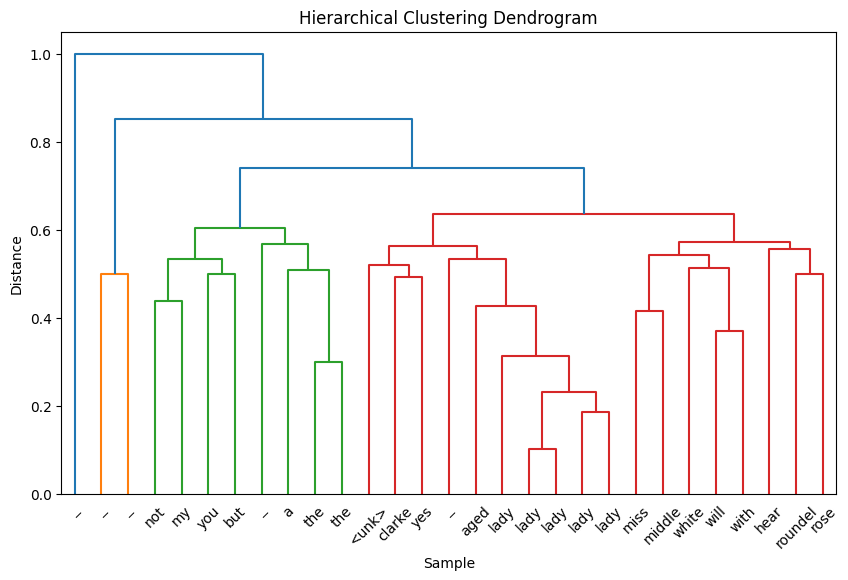

In [64]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=true_words)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()